# Import libraries

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score ,mean_squared_error, r2_score ,confusion_matrix 
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns

In [66]:
file_path = '/kaggle/input/airquality/air_quality_data_all_countries.csv'
air_quality_data = pd.read_csv(file_path)

print(air_quality_data.info())
print(air_quality_data.head()) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    5400 non-null   object 
 1   timestamp  5400 non-null   object 
 2   AQI        5400 non-null   int64  
 3   co         5400 non-null   float64
 4   no         5400 non-null   float64
 5   no2        5400 non-null   float64
 6   o3         5400 non-null   float64
 7   so2        5400 non-null   float64
 8   pm2_5      5400 non-null   float64
 9   pm10       5400 non-null   float64
 10  nh3        5400 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 464.2+ KB
info : 
 None
   country            timestamp  AQI      co    no   no2     o3   so2  pm2_5  \
0  Andorra  2024-10-22 11:00:00    1  178.58  0.45  6.60  45.78  0.54   2.71   
1  Andorra  2024-10-22 12:00:00    1  176.91  0.54  6.34  47.21  0.51   2.76   
2  Andorra  2024-10-22 17:00:00    1  175.24  0.10  8.2

In [72]:
def create_country_windows(data, window_size=5, target_col='AQI'):
    sequences = []
    targets = []
    
    for i in range(window_size, len(data)):
        window = data.iloc[i-window_size:i][['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']].values
        target = data.iloc[i][target_col]
        sequences.append(window)
        targets.append(target)
    
    return sequences, targets

global_sequences = []
global_targets = []

country_sequence_counts = {}

for country in air_quality_data['country'].unique():
    country_data = air_quality_data[air_quality_data['country'] == country]
    country_sequences, country_targets = create_country_windows(country_data, window_size=4, target_col='AQI')
    global_sequences.extend(country_sequences)
    global_targets.extend(country_targets)
    country_sequence_counts[country] = len(country_sequences)

for country, count in country_sequence_counts.items():
    print(f"Country: {country}, Number of sequences: {count}")


Country: Andorra, Number of sequences: 116
Country: United Arab Emirates, Number of sequences: 116
Country: Afghanistan, Number of sequences: 116
Country: Albania, Number of sequences: 116
Country: Anguilla, Number of sequences: 116
Country: Armenia, Number of sequences: 116
Country: Netherlands Antilles, Number of sequences: 116
Country: Angola, Number of sequences: 116
Country: Antarctica, Number of sequences: 116
Country: American Samoa, Number of sequences: 116
Country: Austria, Number of sequences: 116
Country: Australia, Number of sequences: 116
Country: Aruba, Number of sequences: 116
Country: Azerbaijan, Number of sequences: 116
Country: Bosnia and Herzegovina, Number of sequences: 116
Country: Barbados, Number of sequences: 116
Country: Bangladesh, Number of sequences: 116
Country: Belgium, Number of sequences: 116
Country: Burkina Faso, Number of sequences: 116
Country: Bulgaria, Number of sequences: 116
Country: Bahrain, Number of sequences: 116
Country: Burundi, Number of s

## Machine Learning approach 

###  Random forest

In [73]:
# Assuming X_global and y_global are already prepared
X = np.array(global_sequences)
y = np.array(global_targets)

print("X shape before reshaping:", X.shape) 

n_samples, time_steps, n_features = X.shape
X = X.reshape(n_samples, time_steps * n_features) 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


X shape before reshaping: (5220, 4, 8)
Accuracy: 0.8505747126436781
              precision    recall  f1-score   support

           1       0.91      0.93      0.92       585
           2       0.80      0.79      0.80       296
           3       0.68      0.61      0.64        74
           4       0.68      0.70      0.69        56
           5       0.87      0.79      0.83        33

    accuracy                           0.85      1044
   macro avg       0.79      0.76      0.77      1044
weighted avg       0.85      0.85      0.85      1044



## Deep Learning approach Time Series 

### LSTM 

In [86]:
# Assuming X_global and y_global are already prepared
X = np.array(global_sequences)
y = np.array(global_targets)

print("X shape:", X.shape) 
print("y shape:", y.shape)

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("X_train shape:", X_train.shape) 
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape) 
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape) 
print("y_val shape:", y_val.shape)

y_train -= 1
y_val -= 1
y_test -= 1


# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax') 
])

# Compile the model
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X shape: (5220, 4, 8)
y shape: (5220,)
X_train shape: (3654, 4, 8)
y_train shape: (3654,)
X_test shape: (783, 4, 8)
y_test shape: (783,)
X_val shape: (783, 4, 8)
y_val shape: (783,)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [87]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0.0001, mode='min', verbose=1)
ckpt = ModelCheckpoint(monitor='val_accuracy',filepath="/kaggle/working/best.keras", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, patience=5, verbose=1, min_lr=0.000001)

# Train the model
history = model.fit(X_train, 
                    y_train,
                    epochs=100,
                    batch_size=16, 
                    validation_data=(X_val,y_val), 
                    callbacks=[early_stopping, ckpt, reduce_lr],
                    verbose=1)

Epoch 1/100
226/229 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6059 - loss: 1.0162
Epoch 1: val_accuracy improved from -inf to 0.74585, saving model to /kaggle/working/best.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6066 - loss: 1.0135 - val_accuracy: 0.7458 - val_loss: 0.6237 - learning_rate: 0.0010
Epoch 2/100
228/229 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7010 - loss: 0.7087
Epoch 2: val_accuracy improved from 0.74585 to 0.75479, saving model to /kaggle/working/best.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7010 - loss: 0.7085 - val_accuracy: 0.7548 - val_loss: 0.5944 - learning_rate: 0.0010
Epoch 3/100
228/229 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7200 - loss: 0.6345
Epoch 3: val_accuracy improved from 0.75479 to 0.78033, saving model to /kaggle/working/best.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7200 - loss: 0.6345 - val_accuracy: 0.7803 - val_loss: 0.5393 - learning_rate: 0.0010
Epoch 4/100
228/

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8467432950191571

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       418
           1       0.79      0.79      0.79       233
           2       0.68      0.57      0.62        63
           3       0.75      0.84      0.79        45
           4       0.86      0.79      0.83        24

    accuracy                           0.85       783
   macro avg       0.80      0.78      0.79       783
weighted avg       0.84      0.85      0.85       783



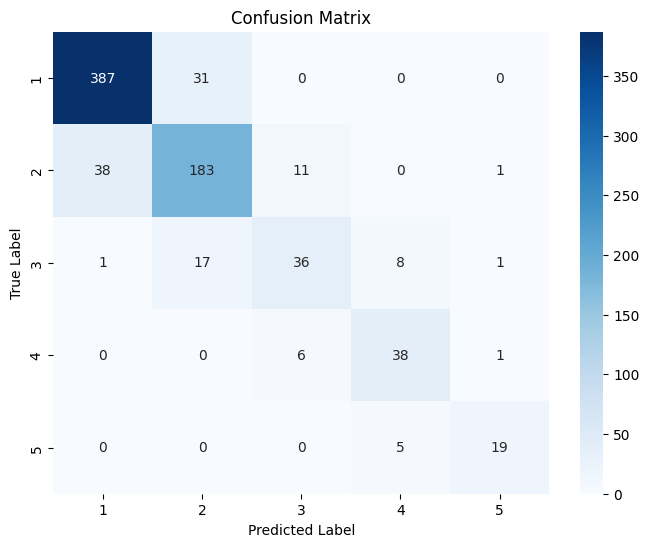

In [84]:
y_pred=model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

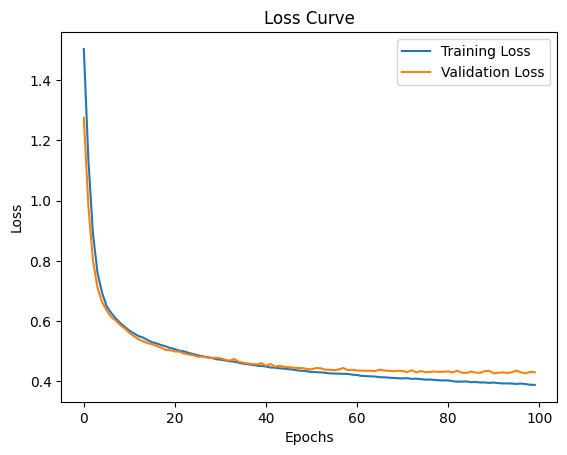

In [40]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [62]:
idx=random.randint(0,len(X_global))
print(' random sample ' , X_global[idx]) 
flattened_sample=X_global[idx].reshape(5 * 8)
print('flattened sample' ,flattened_sample )

print('true target ', y_global[idx])

pred=model.predict(np.expand_dims(flattened_sample,axis=0))
print('predicted target ', pred[0] )

 random sample  [[240.33   0.     5.74  44.7    0.39  11.71  13.25   0.3 ]
 [257.02   2.49   5.48  49.35   0.86  15.07  17.57   0.97]
 [247.     1.58   4.8   67.23   0.78  15.    17.16   0.9 ]
 [223.64   0.     8.83  65.09   0.8    9.91  11.66   0.91]
 [230.31   0.     9.17  59.37   0.95  10.16  12.19   1.03]]
flattened sample [240.33   0.     5.74  44.7    0.39  11.71  13.25   0.3  257.02   2.49
   5.48  49.35   0.86  15.07  17.57   0.97 247.     1.58   4.8   67.23
   0.78  15.    17.16   0.9  223.64   0.     8.83  65.09   0.8    9.91
  11.66   0.91 230.31   0.     9.17  59.37   0.95  10.16  12.19   1.03]
true target  2
predicted target  2
